<a href="https://colab.research.google.com/github/ccwu0918/yolov7-colab/blob/main/01_%E5%BB%BA%E7%AB%8BDarknet%E7%B6%B2%E8%B7%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv4物件辨識演算法，使用Colab
本課程將介紹Darknet為框架所建立的YOLOv4演算法，並會使用照片或即時影像進行分析

步驟1：連結到自己的雲端硬碟，後續可以直接啟用辨識

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


步驟2：將路徑移動到自己的雲端硬碟

In [ ]:
import os
if os.path.exists('/content/drive/MyDrive/Colab Notebooks'):
  %cd "/content/drive/MyDrive/Colab Notebooks"
%ls -al

步驟3：載入相依性套件

In [3]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Darknet神經網路建立
我們使用的Darknet為Alex版本的Darknet網路框架

步驟4：將計畫檔複製到我們的雲端硬碟

In [7]:
# clone darknet repo
if not os.path.exists('darknet'):
  !git clone https://github.com/AlexeyAB/darknet

步驟5：修改編譯設定，主要是因為Colab雲端電腦有提供高效能GPU，所以我們使用Nvidia所提供的Cuda平行運算架構來建立Darknet。

In [8]:
# change makefile to have GPU, OPENCV and LIBSO enabled
if os.path.exists('darknet'):
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
  !sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/drive/MyDrive/Colab Notebooks/darknet


步驟6：編譯Darknet（需要1-3分鐘左右）

In [10]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
if not os.path.exists("libcudnn_so"):
  !make

步驟7：下載YOLOv4 Pre-Train類神經網路模型的權重檔，本模型能辨識日常生活中的80個物件，相關資料都在cfg/coco.names中

YOLOv4：全模型，有162層CNN所建立的類神經網路，正確率較高

YOLOv4-tiny：精簡模型，只有38層，效率高，但辨識率不佳

In [11]:
if not os.path.exists("yolov4-tiny.weights"):
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
if not os.path.exists("yolov4.weights"):  
  !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

## Darknet for Python
步驟8：載入Darknet

這部份為使用Darknet所需要的一些功能，其中第2行所載入的路徑，必須要注意
包含三個設定：cfg網路設定檔，data能辨識的物件名稱，weights類神經網路權重檔

In [12]:
# %cd darknet

In [13]:
!whereis libcudnn.so.
!ls /usr/lib/x86_64-linux-gnu/libcudnn.so -al
!ls /usr/lib/x86_64-linux-gnu/libcudnn.so.8 -al

libcudnn.so: /usr/lib/x86_64-linux-gnu/libcudnn.so /usr/lib/x86_64-linux-gnu/libcudnn.so.8
lrwxrwxrwx 1 root root 29 Oct 28 03:19 /usr/lib/x86_64-linux-gnu/libcudnn.so -> /etc/alternatives/libcudnn_so
lrwxrwxrwx 1 root root 17 Feb 25  2021 /usr/lib/x86_64-linux-gnu/libcudnn.so.8 -> libcudnn.so.8.1.1


In [ ]:
#!cp /etc/alternatives/libcudnn_so .
#!cp /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.1 .

In [ ]:
# !cp /content/drive/MyDrive/Colab\ Notebooks/darknet/libcudnn_so /etc/alternatives/libcudnn_so
# !cp /content/drive/MyDrive/Colab\ Notebooks/darknet/libcudnn.so.8.1.1 /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.1 

In [ ]:
# !ln -s /etc/alternatives/libcudnn_so /usr/lib/x86_64-linux-gnu/libcudnn.so
# !ln -s /usr/lib/x86_64-linux-gnu/libcudnn.so.8.1.1 /usr/lib/x86_64-linux-gnu/libcudnn.so.8

In [14]:
from darknet import *
network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## 測試
步驟9：先使用內建的照片進行測試，內建的照片都放在data中，可以用雲端硬碟來事先查看

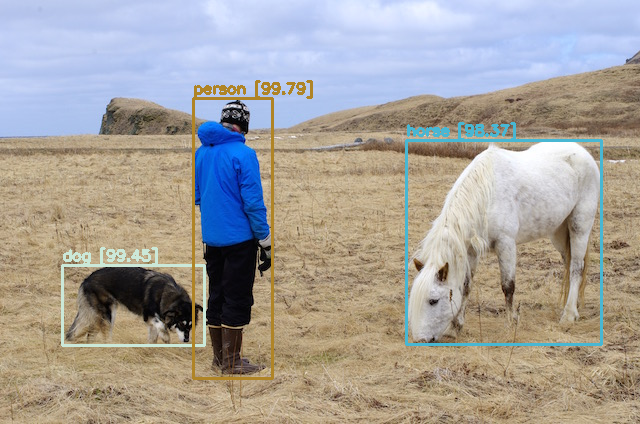

In [15]:
image = cv2.imread("data/person.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)

for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)

cv2_imshow(image)

步驟10：上傳一張照片測試看看

從網路上，搜尋一張照片，例如「路口」，下載後重新命名為「test.jpg」，上傳到darknet/data底下，並執行看看

步驟11：思考一下，如何修改程式碼，可以計算出畫面中的人數？


In [16]:
!wget https://www.upmedia.mg/upload/article/20200904161256111093.JPG
!mv 20200904161256111093.JPG test.jpg

--2022-12-26 20:28:43--  https://www.upmedia.mg/upload/article/20200904161256111093.JPG
Resolving www.upmedia.mg (www.upmedia.mg)... 192.124.249.65
Connecting to www.upmedia.mg (www.upmedia.mg)|192.124.249.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462148 (451K) [image/jpeg]
Saving to: ‘20200904161256111093.JPG’

2020090416125611109 100%[===================>] 451.32K  1.67MB/s    in 0.3s    

2022-12-26 20:28:45 (1.67 MB/s) - ‘20200904161256111093.JPG’ saved [462148/462148]



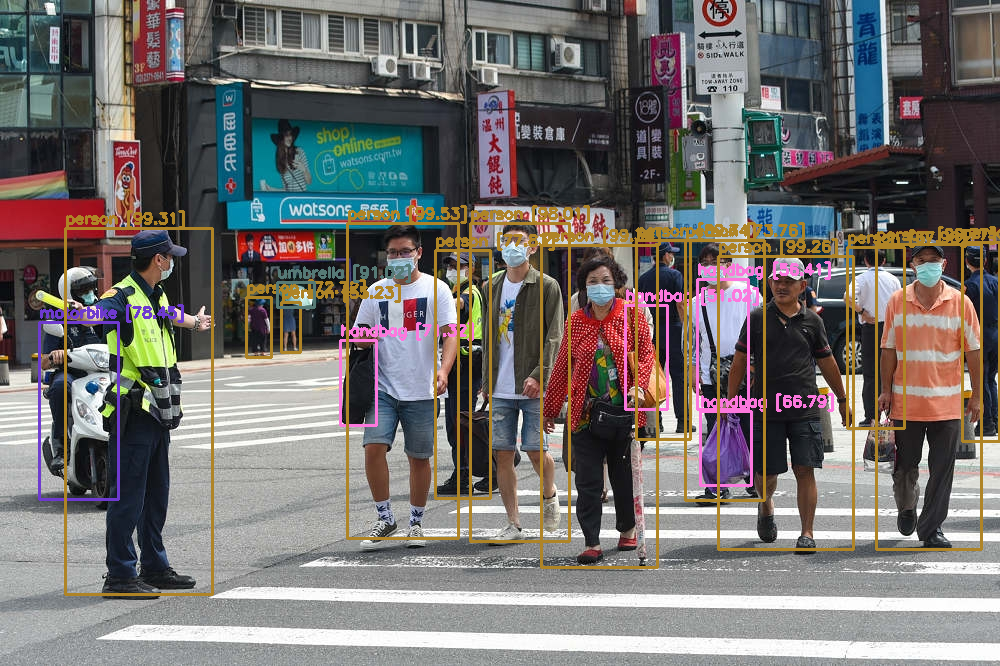

In [17]:
#https://www.upmedia.mg/upload/article/20200904161256111093.JPG
image = cv2.imread("test.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)
cv2_imshow(image)

圖片中handbag的數量有4
圖片中person的數量有13
圖片中motorbike的數量有1
圖片中umbrella的數量有1


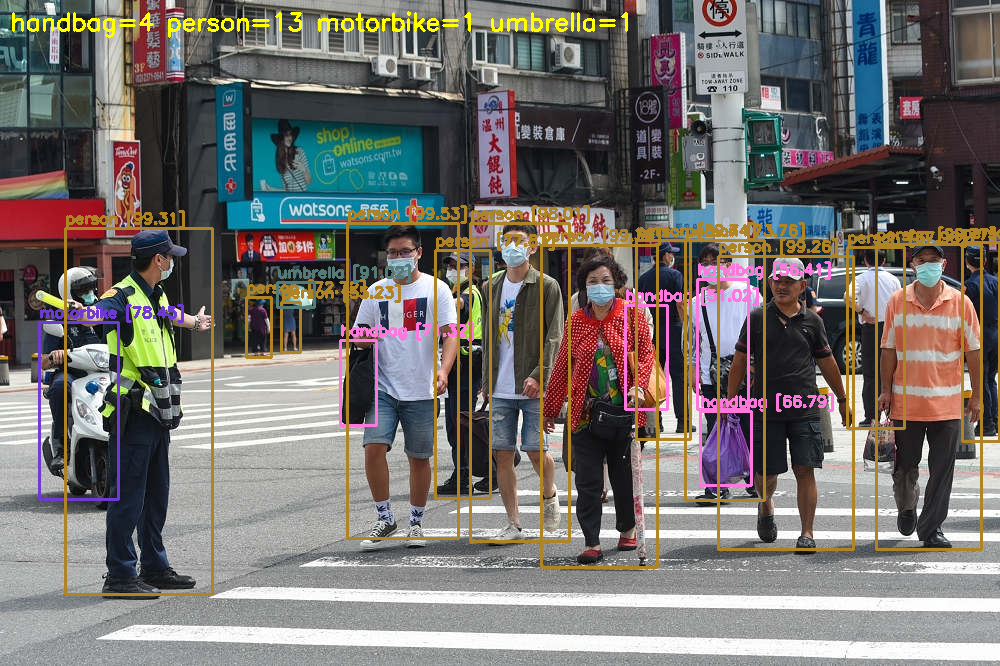

In [18]:
#https://www.upmedia.mg/upload/article/20200904161256111093.JPG
image = cv2.imread("test.jpg")
detections, width_ratio, height_ratio = darknet_helper(image, width, height)
objs={}
for label, confidence, bbox in detections:
  left, top, right, bottom = bbox2points(bbox) #比例
  left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio) #像素座標
  cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2) #繪出方形(bbox)
  #      照片    文字內容                     位置         字形          大小   顏色      寬度
  cv2.putText(image, "{} [{:.2f}]".format(label, float(confidence)),(left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,class_colors[label], 2)
  if label in objs:
    objs[label]+=1
  else:
    objs[label]=1
obj_str = ""
for obj_ in objs:
  obj_str += obj_ + ("=" + str(objs[obj_]) + " ")
  print(f'圖片中{obj_}的數量有{objs[obj_]}')
cv2.putText(image, obj_str,(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8,(0,255,255), 2)
cv2_imshow(image)